In [137]:
%pylab inline
import numpy as np
import pandas as pd
import os
import Hamiltonian
import MoireLattice
from scipy import linalg as la

Populating the interactive namespace from numpy and matplotlib


In [92]:
pathMAC="/Users/jfmv/Documents/Proyectos/Moire-Phonon_QMC/BM_bandstructure"
pathchow='/home/jfm343/Documents/Moire_phonon/BM_bandstructure'
path=pathMAC+'/Mods/data20_mode_L_symmetry_a_alpha_0.0_beta_1.0_umklp_0_kappa_0.8174358974358973_theta_0.01832595714594046.h5'
df = pd.read_hdf(path)

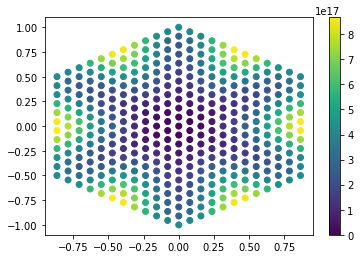

In [93]:
df_prime=df.loc[df['nu']==0]
scatter(df_prime['kx'],df_prime['ky'], c=df_prime['bub'])
colorbar()

Text(0, 0.5, '$\\alpha/ c_L$')

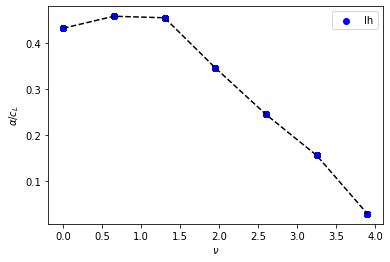

In [94]:

fillings=df['nu']
cep=df['delt_cph']/21400
plt.scatter(fillings, cep, c='b', label='lh')
plt.plot(fillings, cep, c='k', ls='--')
plt.legend()
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\alpha/ c_L$")
# plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


## For the twist angle

In [178]:
kappa=0.75
path=pathMAC+'/data/thetasweep_kappa_'+str(kappa)+'_N30'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
tdos=[]
thetass=[]
eners=[]
fils=[]
for i, pat in enumerate(subpaths):
    # print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)

    

    Nsamp=80
    theta=dff['theta'][0]
    l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
    lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
    [q1,q2,q3]=l.q
    q=la.norm(q1)
    
    #JY params 
    hbvf = 2.7; # eV
    hvkd=hbvf*q
    up = 0.105; # eV
    u = kappa*up; # eV
    alpha=up/hvkd
    alph=alpha
    PH=True
    nbands=2

    # print("Loading  ..........")
    with open(fulpath+'/dispersions/Edisp_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'.npy', 'rb') as f:
        Ene_valley_plus_dos=np.load(f)
    with open(fulpath+'/dispersions/Edism_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'.npy', 'rb') as f:
        Ene_valley_min_dos=np.load(f)

    hpl=Hamiltonian.Ham_BM_p(hvkd, alph, 1, lq, kappa, PH)
    hmin=Hamiltonian.Ham_BM_m(hvkd, alph, -1, lq, kappa, PH)

    Ndos=80
    ldos=MoireLattice.MoireTriangLattice(Ndos,theta,2)
    disp=Hamiltonian.Dispersion( ldos, nbands, hpl, hmin)
    [earr, dos, f2 ]=disp.DOS(Ene_valley_plus_dos,Ene_valley_min_dos)


    NN=2000
    mine=earr[1]
    maxe=earr[-2]
    mus=np.linspace(mine,maxe, NN)
    dosarr=f2(mus)
    de=mus[1]-mus[0]

    #FILLING FOR EACH CHEMICAL POTENTIAL
    ndens=[]
    for mu_ind in range(NN):
        N=np.trapz(dosarr[0:mu_ind])*de
        ndens.append(N)
            
    nn=np.array(ndens)
    nn=8*(nn/nn[-1])  - 4

    tdos.append(dosarr)
    thetass.append(theta)
    eners.append(mus)
    fils.append(nn)
    #
df=pd.concat(frames).sort_values(['theta', 'nu'])

thetass,tdos,eners,fils = zip(*sorted(zip(thetass,tdos,eners,fils)))


starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.2923300266265869  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.999999999999935
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.30445003509521484  s
number of bands in density of states calculation, 2
sum of the hist, normed? 8.000000000000007
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.2978849411010742  s
number of bands in density of states calculation, 2
sum of the hist, normed? 8.000000000000068
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.27645111083984375  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.999999999999997
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.2742807865142822  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7

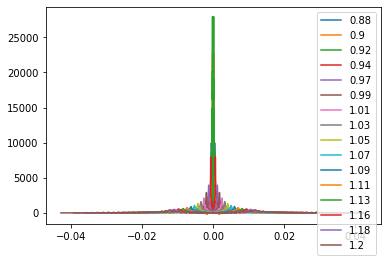

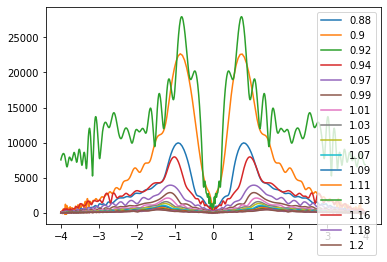

In [181]:
for i,t in enumerate(tdos):
    plot(eners[i],t, label=round(thetass[i]*180/np.pi,2))
legend(loc=1)

plt.show()


for i,t in enumerate(tdos):
    plot(fils[i],t, label=round(thetass[i]*180/np.pi,2))
legend(loc=1)

plt.show()


[Text(0, 0.5, '0.0'),
 Text(0, 1.5, '0.65'),
 Text(0, 2.5, '1.3'),
 Text(0, 3.5, '1.95'),
 Text(0, 4.5, '2.6'),
 Text(0, 5.5, '3.25'),
 Text(0, 6.5, '3.9')]

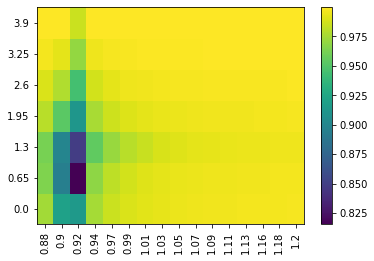

In [182]:

dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)


ax.set_xticks(np.arange(tablenuthet.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(tablenuthet.shape[0]) + 0.5, minor=False)

# # Rotate the xlabels. Set both x and y labels to headers[1:]
thets=(dataframeatgamma['theta'].unique()*180/np.pi).round(decimals=2)
nus=(dataframeatgamma['nu'].unique()).round(decimals=2)
ax.set_xticklabels(thets,rotation=90)
ax.set_yticklabels(nus)



In [183]:
kappa=0.75
path=pathMAC+'/data/thetasweep_kappa_'+str(kappa)+'_PHflalse/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
tdos=[]
thetass=[]
eners=[]
fils=[]
for i, pat in enumerate(subpaths):
    # print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)

    

    Nsamp=80
    theta=dff['theta'][0]
    l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
    lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
    [q1,q2,q3]=l.q
    q=la.norm(q1)
    
    #JY params 
    hbvf = 2.7; # eV
    hvkd=hbvf*q
    up = 0.105; # eV
    u = kappa*up; # eV
    alpha=up/hvkd
    alph=alpha
    PH=True
    nbands=2

    # print("Loading  ..........")
    with open(fulpath+'/dispersions/Edisp_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'.npy', 'rb') as f:
        Ene_valley_plus_dos=np.load(f)
    with open(fulpath+'/dispersions/Edism_'+str(lq.Npoints)+'_theta_'+str(lq.theta)+'.npy', 'rb') as f:
        Ene_valley_min_dos=np.load(f)

    hpl=Hamiltonian.Ham_BM_p(hvkd, alph, 1, lq, kappa, PH)
    hmin=Hamiltonian.Ham_BM_m(hvkd, alph, -1, lq, kappa, PH)

    Ndos=80
    ldos=MoireLattice.MoireTriangLattice(Ndos,theta,2)
    disp=Hamiltonian.Dispersion( ldos, nbands, hpl, hmin)
    [earr, dos, f2 ]=disp.DOS(Ene_valley_plus_dos,Ene_valley_min_dos)


    NN=2000
    mine=earr[1]
    maxe=earr[-2]
    mus=np.linspace(mine,maxe, NN)
    dosarr=f2(mus)
    de=mus[1]-mus[0]

    #FILLING FOR EACH CHEMICAL POTENTIAL
    ndens=[]
    for mu_ind in range(NN):
        N=np.trapz(dosarr[0:mu_ind])*de
        ndens.append(N)
            
    nn=np.array(ndens)
    nn=8*(nn/nn[-1])  - 4

    tdos.append(dosarr)
    thetass.append(theta)
    eners.append(mus)
    fils.append(nn)
    #
df=pd.concat(frames).sort_values(['theta', 'nu'])

thetass,tdos,eners,fils = zip(*sorted(zip(thetass,tdos,eners,fils)))

starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.27786707878112793  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.9999999999998614
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.27970099449157715  s
number of bands in density of states calculation, 2
sum of the hist, normed? 8.000000000000004
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.3801698684692383  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.999999999999955
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.3910698890686035  s
number of bands in density of states calculation, 2
sum of the hist, normed? 7.999999999999962
starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.3683290481567383  s
number of bands in density of states calculation, 2
sum of the hist, normed? 

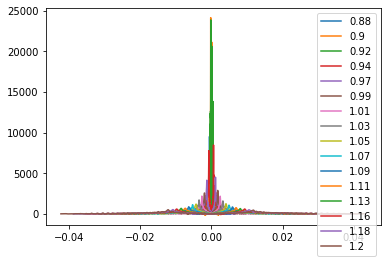

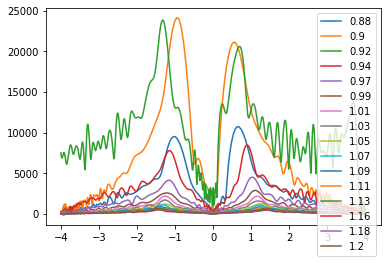

In [184]:
for i,t in enumerate(tdos):
    plot(eners[i],t, label=round(thetass[i]*180/np.pi,2))
legend(loc=1)

plt.show()


for i,t in enumerate(tdos):
    plot(fils[i],t, label=round(thetass[i]*180/np.pi,2))
legend(loc=1)

plt.show()


[Text(0, 0.5, '0.0'),
 Text(0, 1.5, '0.65'),
 Text(0, 2.5, '1.3'),
 Text(0, 3.5, '1.95'),
 Text(0, 4.5, '2.6'),
 Text(0, 5.5, '3.25'),
 Text(0, 6.5, '3.9')]

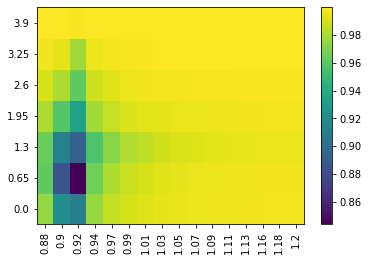

In [122]:

dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)


ax.set_xticks(np.arange(tablenuthet.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(tablenuthet.shape[0]) + 0.5, minor=False)

# # Rotate the xlabels. Set both x and y labels to headers[1:]
thets=(dataframeatgamma['theta'].unique()*180/np.pi).round(decimals=2)
nus=(dataframeatgamma['nu'].unique()).round(decimals=2)
ax.set_xticklabels(thets,rotation=90)
ax.set_yticklabels(nus)


In [185]:

path=pathMAC+'/data/thetasweep_kappa_0.5_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
for i, pat in enumerate(subpaths):
    print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)
df=pd.concat(frames).sort_values(['theta', 'nu'])




thetasweep_kappa_0.5_N30_0.98_2022-01-26-09-57-17
thetasweep_kappa_0.5_N30_0.9_2022-01-26-07-34-22
thetasweep_kappa_0.5_N30_1.0_2022-01-26-08-52-45
thetasweep_kappa_0.5_N30_0.86_2022-01-26-07-18-24
thetasweep_kappa_0.5_N30_1.12_2022-01-26-07-11-47
thetasweep_kappa_0.5_N30_0.96_2022-01-26-10-01-40
thetasweep_kappa_0.5_N30_1.04_2022-01-26-07-20-54
thetasweep_kappa_0.5_N30_1.02_2022-01-26-07-54-54
thetasweep_kappa_0.5_N30_0.88_2022-01-26-06-13-37
thetasweep_kappa_0.5_N30_1.08_2022-01-26-07-30-15
thetasweep_kappa_0.5_N30_1.14_2022-01-26-07-29-04
thetasweep_kappa_0.5_N30_1.1_2022-01-26-07-40-16
thetasweep_kappa_0.5_N30_0.92_2022-01-26-06-21-35
thetasweep_kappa_0.5_N30_0.94_2022-01-26-06-24-40
thetasweep_kappa_0.5_N30_1.06_2022-01-26-06-46-13
thetasweep_kappa_0.5_N30_0.84_2022-01-26-07-37-18


[Text(0, 0.5, '0.0'),
 Text(0, 1.5, '0.65'),
 Text(0, 2.5, '1.3'),
 Text(0, 3.5, '1.95'),
 Text(0, 4.5, '2.6'),
 Text(0, 5.5, '3.25'),
 Text(0, 6.5, '3.9')]

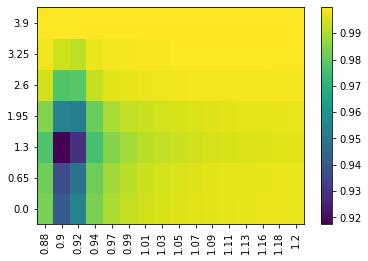

In [186]:

dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)


ax.set_xticks(np.arange(tablenuthet.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(tablenuthet.shape[0]) + 0.5, minor=False)

# # Rotate the xlabels. Set both x and y labels to headers[1:]
thets=(dataframeatgamma['theta'].unique()*180/np.pi).round(decimals=2)
nus=(dataframeatgamma['nu'].unique()).round(decimals=2)
ax.set_xticklabels(thets,rotation=90)
ax.set_yticklabels(nus)

In [125]:

path=pathMAC+'/data/thetasweep_kappa_0.3_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
for i, pat in enumerate(subpaths):
    print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)
df=pd.concat(frames).sort_values(['theta', 'nu'])




thetasweep_kappa_0.3_N30_0.9_2022-01-26-09-08-18
thetasweep_kappa_0.3_N30_1.12_2022-01-26-06-31-49
thetasweep_kappa_0.3_N30_0.98_2022-01-26-07-24-32
thetasweep_kappa_0.3_N30_0.84_2022-01-26-06-17-12
thetasweep_kappa_0.3_N30_1.08_2022-01-26-06-46-28
thetasweep_kappa_0.3_N30_0.92_2022-01-26-06-57-01
thetasweep_kappa_0.3_N30_1.04_2022-01-26-06-14-24
thetasweep_kappa_0.3_N30_1.1_2022-01-26-07-26-43
thetasweep_kappa_0.3_N30_0.88_2022-01-26-06-40-09
thetasweep_kappa_0.3_N30_1.02_2022-01-26-06-57-25
thetasweep_kappa_0.3_N30_1.06_2022-01-26-07-06-30
thetasweep_kappa_0.3_N30_0.86_2022-01-26-06-14-49
thetasweep_kappa_0.3_N30_0.94_2022-01-26-06-15-41
thetasweep_kappa_0.3_N30_1.0_2022-01-26-06-16-37
thetasweep_kappa_0.3_N30_0.96_2022-01-26-07-09-02
thetasweep_kappa_0.3_N30_1.14_2022-01-26-06-16-49


[Text(0, 0.5, '0.0'),
 Text(0, 1.5, '0.65'),
 Text(0, 2.5, '1.3'),
 Text(0, 3.5, '1.95'),
 Text(0, 4.5, '2.6'),
 Text(0, 5.5, '3.25'),
 Text(0, 6.5, '3.9')]

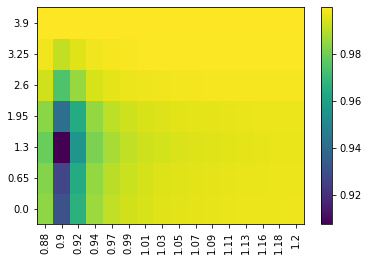

In [126]:

dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)

ax.set_xticks(np.arange(tablenuthet.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(tablenuthet.shape[0]) + 0.5, minor=False)

# # Rotate the xlabels. Set both x and y labels to headers[1:]
thets=(dataframeatgamma['theta'].unique()*180/np.pi).round(decimals=2)
nus=(dataframeatgamma['nu'].unique()).round(decimals=2)
ax.set_xticklabels(thets,rotation=90)
ax.set_yticklabels(nus)

In [127]:

path=pathMAC+'/data/thetasweep_kappa_0.85_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        
thet=[]
renorm=[]
renorm2=[]
frames=[]
for i, pat in enumerate(subpaths):
    print(pat)
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    dff = pd.read_hdf(fullpath)
    frames.append(dff)
df=pd.concat(frames).sort_values(['theta', 'nu'])


thetasweep_kappa_0.85_N30_0.9_2022-01-26-14-23-18
thetasweep_kappa_0.85_N30_1.0_2022-01-26-14-25-21
thetasweep_kappa_0.85_N30_1.14_2022-01-26-14-35-07
thetasweep_kappa_0.85_N30_1.02_2022-01-26-14-24-23
thetasweep_kappa_0.85_N30_1.08_2022-01-26-14-44-38
thetasweep_kappa_0.85_N30_1.1_2022-01-26-14-33-15
thetasweep_kappa_0.85_N30_0.86_2022-01-26-14-07-36
thetasweep_kappa_0.85_N30_0.88_2022-01-26-14-08-09
thetasweep_kappa_0.85_N30_0.92_2022-01-26-14-25-04
thetasweep_kappa_0.85_N30_0.84_2022-01-26-14-06-10
thetasweep_kappa_0.85_N30_0.94_2022-01-26-14-23-02
thetasweep_kappa_0.85_N30_0.98_2022-01-26-14-26-18
thetasweep_kappa_0.85_N30_1.06_2022-01-26-14-32-08
thetasweep_kappa_0.85_N30_1.04_2022-01-26-14-40-32
thetasweep_kappa_0.85_N30_0.96_2022-01-26-14-25-55
thetasweep_kappa_0.85_N30_1.12_2022-01-26-14-37-38


[Text(0, 0.5, '0.0'),
 Text(0, 1.5, '0.65'),
 Text(0, 2.5, '1.3'),
 Text(0, 3.5, '1.95'),
 Text(0, 4.5, '2.6'),
 Text(0, 5.5, '3.25'),
 Text(0, 6.5, '3.9')]

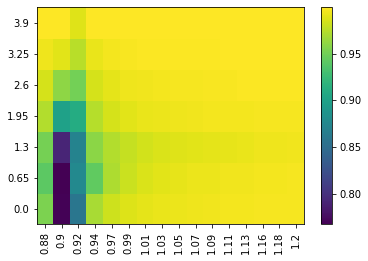

In [128]:
dataframeatgamma=df.loc[(df['kx']==0) & (df['ky']==0)] #since I have all the values of the bubble i need only to take one to check the effective c
tablenuthet=dataframeatgamma.pivot(index='nu', columns='theta', values='delt_cph')
cLong=21400
cep=tablenuthet/cLong
effectivec=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)

fig,ax = plt.subplots()
c=ax.pcolor(effectivec)
fig.colorbar(c, ax=ax)

ax.set_xticks(np.arange(tablenuthet.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(tablenuthet.shape[0]) + 0.5, minor=False)

# # Rotate the xlabels. Set both x and y labels to headers[1:]
thets=(dataframeatgamma['theta'].unique()*180/np.pi).round(decimals=2)
nus=(dataframeatgamma['nu'].unique()).round(decimals=2)
ax.set_xticklabels(thets,rotation=90)
ax.set_yticklabels(nus)

range of twist angles 0.010499999999999954


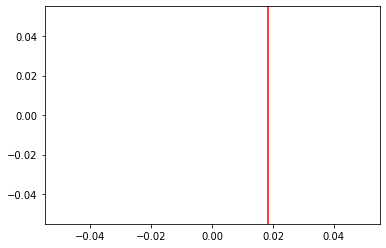

In [129]:
scatter(thet, renorm2)
axvline(1.05*np.pi/180, c='r')
# axvline((1.015)*1.05*np.pi/180, c='k')
# axvline((1.025)*1.05*np.pi/180, c='k')
# axvline((1.02)*1.05*np.pi/180, c='k')
print("range of twist angles", (1.025)*1.05-(1.015)*1.05)
NS=20
# for i in range(NS):
#     l=(i-int(NS/2))*0.005
#     axvline((1+l)*1.05*np.pi/180)
#     print((1+l))

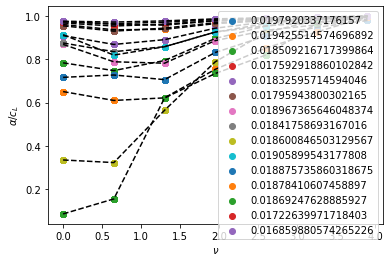

In [130]:
path=pathMAC+'/data/thetasweep_kappa_0.817_beta_4ev_N30/'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        

for i, pat in enumerate(subpaths):
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'L')
    fullpath=fulpath+'/'+data[0]
    
    df = pd.read_hdf(fullpath)
    
    fillings=df['nu']
    cep=df['delt_cph']/21400
    cep2=np.sqrt(np.abs(1-cep**2))*np.heaviside(1-cep**2,0.0)
    plt.scatter(fillings, cep2, label=str(df['theta'][0]))
    plt.plot(fillings, cep2, c='k', ls='--')
    plt.legend()
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\alpha/ c_L$")
    # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


# For kappa

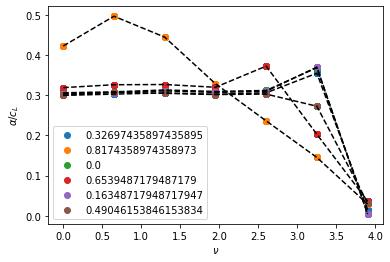

In [10]:
path='/home/jfm343/Documents/Moire_phonon/BM_bandstructure/data/kappasweep_theta_1.05_beta_4ev_N30_2022-01-20-09-58-20'
subpaths=os.listdir(path)
subpaths=list(filter(lambda a: a != 'inforun', subpaths))

def getdatadir(fulpath,mode):
    data=[]
    for pa in fulpath:
        if ('data' in pa) and (mode in pa): data.append(pa)
    return data
        

for i, pat in enumerate(subpaths):
    fulpath=path+'/'+pat
    subpaths2=os.listdir(fulpath)
    data= getdatadir(subpaths2, 'T')
    fullpath=fulpath+'/'+data[0]
    
    df = pd.read_hdf(fullpath)
    
    fillings=df['nu']
    cep=df['delt_cph']/21400
    cep2=np.sqrt(1-cep**2)
    plt.scatter(fillings, cep, label=str(df['kappa'][0]))
    plt.plot(fillings, cep, c='k', ls='--')
    plt.legend()
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$\alpha/ c_L$")
    # plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


In [19]:
import Hamiltonian
import MoireLattice
from scipy import linalg as la

#Lattice parameters 
#lattices with different normalizations
modulation_thet=1
Nsamp=10
theta=modulation_thet*1.05*np.pi/180  # magic angle 
l=MoireLattice.MoireTriangLattice(Nsamp,theta,0) 
lq=MoireLattice.MoireTriangLattice(Nsamp,theta,2) #this one 
[KX,KY]=lq.Generate_lattice()
Npoi=np.size(KX); print(Npoi, "numer of sampling lattice points")
[q1,q2,q3]=l.q
q=la.norm(q1)
umkl=0
print(f"taking {umkl} umklapps")
VV=lq.boundary()

print(q, 2*np.sin(theta/2)*np.pi*(4/3))

starting sampling in reciprocal space....
finished sampling in reciprocal space....t= 0.005800485610961914  s
91 numer of sampling lattice points
taking 0 umklapps
0.07676251561000431 0.0767625156100043
